In [ ]:
from importlib import reload

import jax_L96 as jl
from jax_L96 import jnp
import jax
import numpy as np
from matplotlib import pyplot as plt

reload(jl)

jndarray = jnp.ndarray

In [ ]:
def plot_error(
    fig,
    axs,
    t0: float,
    tf: float,
    dt: float,
    U_true: jndarray,
    V_true: jndarray,
    U_nudge: jndarray,
    V_nudge: jndarray,
):
    """Plot the absolute and relative errors of the nudged solution from the
    true solution.
    """
    tls = np.linspace(t0, tf, len(U_true))

    U_err = np.linalg.norm(U_true - U_nudge, axis=1)
    V_err = np.linalg.norm(V_true - V_nudge, axis=(1, 2))

    U_rel_err = U_err / np.linalg.norm(U_true, axis=1)
    V_rel_err = V_err / np.linalg.norm(V_true, axis=(1, 2))

    ax = axs[0, 0]
    ax.plot(tls, U_err, label=f"dt = {dt}")
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("U absolute error")
    ax.grid()
    ax.legend()

    ax = axs[0, 1]
    ax.plot(tls, U_rel_err)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("U relative error")
    ax.grid()

    ax = axs[1, 0]
    ax.plot(tls, V_err)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("V absolute error")
    ax.grid()

    ax = axs[1, 1]
    ax.plot(tls, V_rel_err)
    ax.set_yscale("log")

    ax.set_xlabel("$t$")
    ax.set_title("V relative error")
    ax.grid()

# Evolve without parameter updates (only nudging)

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
ds = jnp.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

system = jl.System(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)
solver = jl.RK4(system)

In [ ]:
def simulate(t0, tf, dt):
    # Initial true state
    seed = 42
    key = jax.random.key(seed)
    init = jax.random.uniform(key, I + I * J)
    # To be able to compare with NumPy previous work:
    init = np.random.default_rng(42).uniform(size=I + I * J)

    u0 = jnp.array(init[:I])
    v0 = jnp.array(jnp.reshape(init[I:], (I, J)))

    # Initial simulation state
    u0_sim = jnp.zeros_like(u0)
    v0_sim = jnp.zeros_like(v0)

    U, V = solver.solve(
        system,
        u0,
        v0,
        t0,
        tf,
        dt,
    )

    # Nudged solution
    Un, Vn = solver.solve(
        system,
        u0_sim,
        v0_sim,
        t0,
        tf,
        dt,
        U,
    )

    return U, V, Un, Vn

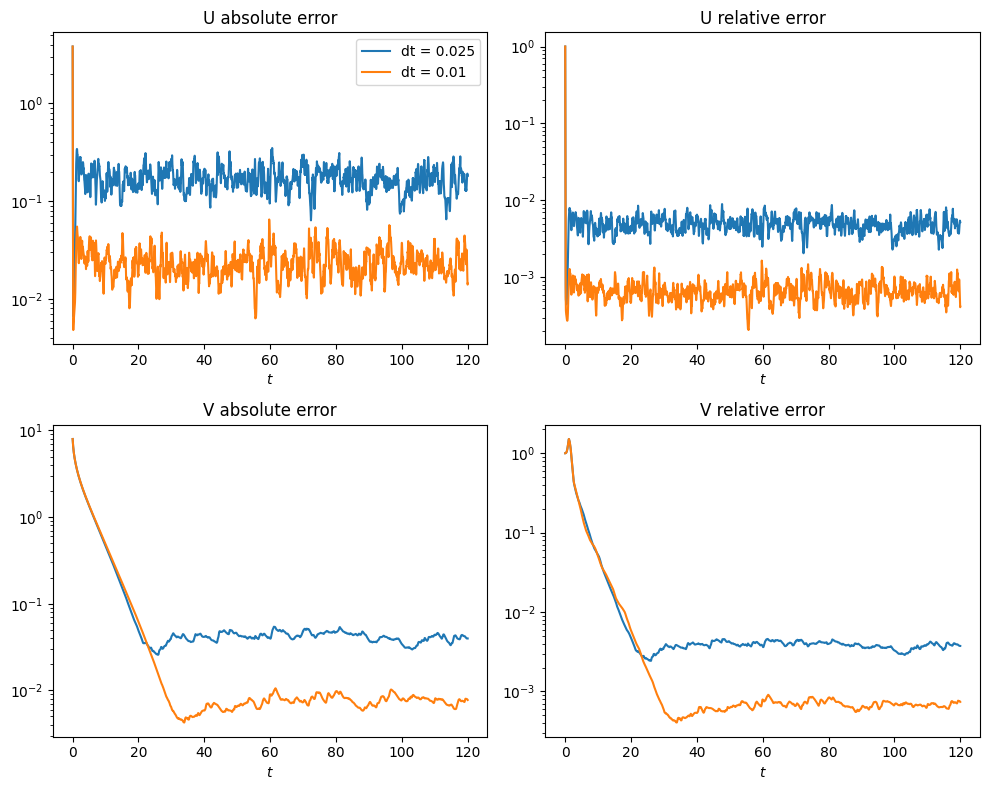

In [ ]:
t0, tf = 0, 120

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for dt in (0.025, 0.01):#, 0.001, 0.0001):
    U, V, Un, Vn = simulate(t0, tf, dt)
    
    plot_error(fig, axs, t0, tf, dt, U, V, Un, Vn)

fig.tight_layout()
plt.show()